# Functionalizing the SINDy-SHRED pipeline

This iPython notebook gives an introductory walkthrough to using SHRED models.  The dataset we consider is weekly mean sea-surface temperature as given by the NOAA Optimum Interpolation SST V2 dataset (https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html).

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as 
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

SINDy-SHRED further extends the SHRED architecture by integrating **Sparse Identification of Nonlinear Dynamics (SINDy)** into the recurrent decoder framework. The key idea is to enforce a **parsimonious latent space representation**, where the dynamics of the latent variables are governed by a **sparse set of basis functions**. 

More formally, SINDy-SHRED introduces an additional inductive bias:

$$\dot{z} = \Theta(z) \xi$$

where:

- $z = \mathcal{G} \left( \{ y_i \} _{i=t-k}^t \right)$ represents the **latent space variables** extracted by the LSTM encoder.
- $\Theta(z)$ is a **library of candidate nonlinear functions**.
- $\xi$ is a **sparse coefficient matrix** that determines the governing equations.

This combination enables **interpretable spatio-temporal modeling** by ensuring that the learned representations adhere to a **governing law**, making the method suitable for **data-driven discovery of dynamical systems** from high-dimensional, noisy observations.

In this notebook, we will walk through the application of **SINDy-SHRED** on the **weekly mean sea-surface temperature (SST) dataset**, demonstrating how the model can **learn a reduced-order latent representation** and **recover the governing equations** that describe the SST evolution.

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, corresponding to one year of measurements.

In [14]:
import glob
import os
import random
import sys
import warnings
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysindy as ps

# netcdf/numpy/xray/stats
import scipy

# import plotting
import seaborn as sns
import sindy
import sindy_shred
import driver as model_driver
import torch
from pysindy.differentiation import FiniteDifference
from scipy.integrate import solve_ivp

warnings.filterwarnings("ignore")

In [15]:
def relative_error(x_est, x_true):
    """Helper function for calculating the relative error.

    :param x_est: Estimated values (i.e. from reconstruction)
    :type x_est: numpy.ndarray
    :param x_true: True (or observed) values.
    :type x_true: numpy.ndarray
    :return: Relative error between observations and model.
    :rtype: numpy.ndarray
    """
    return np.linalg.norm(x_est - x_true) / np.linalg.norm(x_true)

In [16]:
dir_print = os.path.join(dir_project, "figures/mrCOSTS/method exploration")
dir_fits = os.path.join(
    dir_project, "notebooks/mrdmd/tutorials and unit tests/fitted model"
)

In [17]:
pcolor_kwargs = {
    "vmin": -3,
    "vmax": 3,
    "cmap": "RdBu_r",
}

In [18]:
def rhs_FNM(t, x, tau, a, b, Iext):
    """FitzHugh-Nagumo Model

    See costs-tutorial_toy-data for details.
    """
    v = x[0]
    w = x[1]
    vdot = v - (v**3) / 3 - w + Iext
    wdot = (1 / tau) * (v + a - b * w)
    dx = np.array([vdot, wdot])

    return dx


def rhs_UFD(t, y, eta, epsilon, tau):
    """Unforced Duffing Oscillator

    See costs-tutorial_toy-data for details.
    """
    p = y[0]
    q = y[1]
    pdot = q
    qdot = (1 / tau) * (-2 * eta * q - p - epsilon * p**3)
    dy = np.array([pdot, qdot])

    return dy


T = 64

x0 = np.array([-1.110, -0.125])
tau1 = 2
a = 0.7
b = 0.8
Iext = 0.65

y0 = np.array([0, 1])
eta = 0
epsilon = 1
tau2 = 0.2

# RK4 integration of the mixed system
dt = 0.0001 * 8
t_solution = np.arange(0, T, dt)

# Solve the FitzHugh-Nagumo Model
solution_fn = solve_ivp(rhs_FNM, [0, T], x0, t_eval=t_solution, args=(tau1, a, b, Iext))

# Solve the Unforced Duffing Oscillator Model
solution_ufd = solve_ivp(
    rhs_UFD, [0, T], y0, t_eval=t_solution, args=(eta, epsilon, tau2)
)

seed = 1
num_space_dims = 10

uv_tiled = np.hstack(
    [
        np.tile(solution_fn.y.T, num_space_dims),
        np.tile(solution_ufd.y.T, num_space_dims),
    ]
)

# Subsample after solving the pdes
substep = 50
uv_tiled = uv_tiled[0::substep, :]
t_solution = t_solution[0::substep]
time = t_solution
dt = time[1] - time[0]
dt_data = np.copy(dt)

# Dimension of space to map into
n_space_dims = np.shape(uv_tiled)[1]
n_time = np.shape(uv_tiled)[0]

# Orthonormalized linear mixing matrix
Q = scipy.stats.ortho_group.rvs(n_space_dims, random_state=seed)
Q = Q[0:n_space_dims, :]
x = uv_tiled @ Q

# COSTS expects time by space, so we transpose x.
data_original = x.T

# For the scale separation we want to compare to the actual slow and fast
# components.
slow_modes = uv_tiled[:, 0 : n_space_dims // 2] @ Q[0 : n_space_dims // 2, :]
fast_modes = uv_tiled[:, n_space_dims // 2 :] @ Q[n_space_dims // 2 :, :]

space_dim = np.arange(n_space_dims)
xgrid, tgrid = np.meshgrid(space_dim, time)

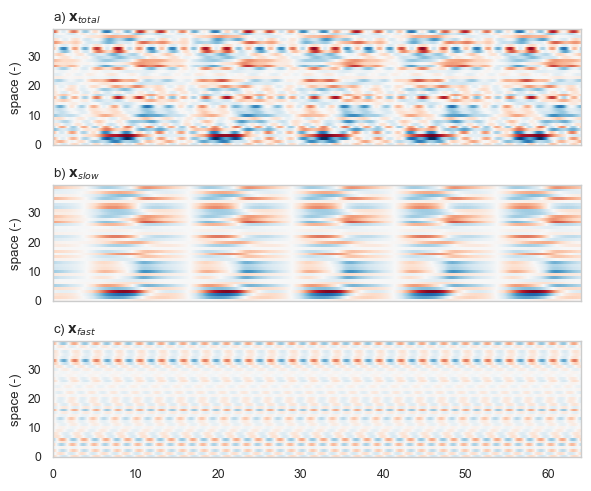

In [19]:
sns.set_context("paper")
sns.set_style("whitegrid")

fig, axes = plt.subplots(3, 1, figsize=(6, 5), sharex=True, sharey=True)

pcolor_kwargs = {
    "vmin": -3,
    "vmax": 3,
    "cmap": "RdBu_r",
    "rasterized": True,
}

# Original data
ax = axes[0]
ax.pcolor(time, space_dim, data_original, **pcolor_kwargs)
ax.set_title(r"a) $\mathbf{x}_{total}$", loc="left")
ax.set_ylabel("space (-)")

ax = axes[1]
ax.pcolor(time, space_dim, slow_modes.T, **pcolor_kwargs)
ax.set_title(r"b) $\mathbf{x}_{slow}$", loc="left")
ax.set_ylabel("space (-)")

ax = axes[2]
ax.pcolor(time, space_dim, fast_modes.T, **pcolor_kwargs)
ax.set_title(r"c) $\mathbf{x}_{fast}$", loc="left")
ax.set_ylabel("space (-)")

fig.tight_layout()
plt.show()

# SINDy-SHRED

Set random seed

In [20]:
# Set this BEFORE importing torch if you need to control GPU access
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# Choose device
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

# Set seeds for reproducibility
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Optional: CUDA-specific seed (only if using CUDA)
if device == "cuda":
    torch.cuda.manual_seed(0)

# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

We now select indices to divide the data into training, validation, and test sets.

## Specify data to fit

In [38]:
# Remove randomness for investigation
sensor_locations = np.array([10, 28, 14, 11, 23, 27])
num_sensors = len(sensor_locations)

# Threshold for identifying sparse dynamics in SINDy
threshold = 0.0

latent_dim = 4
poly_order = 1
include_sine = False
# This is required to be True as it is baked into the code at the moment.
include_constant = True
library_dim = sindy.library_size(latent_dim, poly_order, include_sine, include_constant)

lags = 120
train_length = 750 // 4
validate_length = 0
load_X = copy.deepcopy(data_original)

# Sub-sample for speed up
load_X = load_X.T[::4]
dt = dt_data * 4
lags = lags // 4

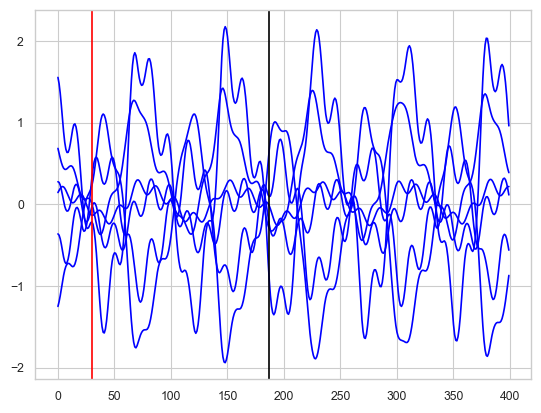

In [39]:
plt.plot(load_X[:, sensor_locations], color='b')
plt.gca().axvline(train_length, color='k')
plt.gca().axvline(lags, color='r')

## Fit SINDy-SHRED

In [40]:
driver = model_driver.sindy_shred_driver(latent_dim=latent_dim, poly_order=poly_order, verbose=True)
driver.fit(
    num_sensors,
    dt,
    load_X,
    lags,
    train_length,
    validate_length,
    sensor_locations
)

1 : tensor(0.2842, device='mps:0', grad_fn=<AddBackward0>)
2 : tensor(0.1833, device='mps:0', grad_fn=<AddBackward0>)
3 : tensor(0.1018, device='mps:0', grad_fn=<AddBackward0>)
4 : tensor(0.0910, device='mps:0', grad_fn=<AddBackward0>)
5 : tensor(0.1069, device='mps:0', grad_fn=<AddBackward0>)
6 : tensor(0.0902, device='mps:0', grad_fn=<AddBackward0>)
7 : tensor(0.0738, device='mps:0', grad_fn=<AddBackward0>)
8 : tensor(0.0718, device='mps:0', grad_fn=<AddBackward0>)
9 : tensor(0.0760, device='mps:0', grad_fn=<AddBackward0>)
10 : tensor(0.0734, device='mps:0', grad_fn=<AddBackward0>)
11 : tensor(0.0651, device='mps:0', grad_fn=<AddBackward0>)
12 : tensor(0.0543, device='mps:0', grad_fn=<AddBackward0>)
13 : tensor(0.0484, device='mps:0', grad_fn=<AddBackward0>)
14 : tensor(0.0472, device='mps:0', grad_fn=<AddBackward0>)
15 : tensor(0.0431, device='mps:0', grad_fn=<AddBackward0>)
16 : tensor(0.0406, device='mps:0', grad_fn=<AddBackward0>)
17 : tensor(0.0374, device='mps:0', grad_fn=<AddB

## Posthoc dynamics discovery

SINDy-derived dynamical equation:

(x0)' = -0.267 1 + 2.631 x0 + 5.960 x1 + 4.831 x2 + -1.503 x3
(x1)' = 0.066 1 + -0.554 x0 + -1.746 x1 + -0.804 x2 + 1.237 x3
(x2)' = -0.007 1 + -1.005 x0 + -0.266 x1 + -1.020 x2 + -1.310 x3
(x3)' = -0.133 1 + 1.116 x0 + 1.768 x1 + 2.374 x2 + 0.182 x3


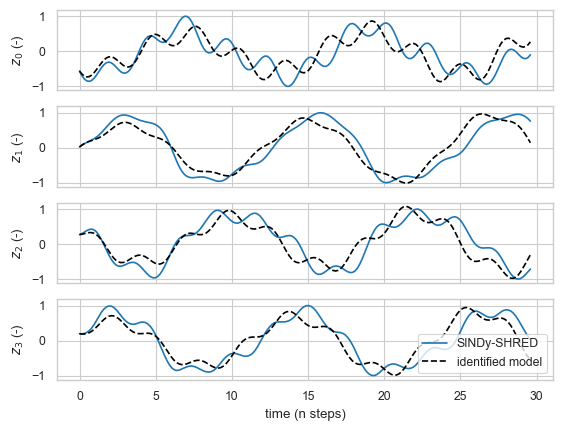

<Figure size 640x480 with 0 Axes>

In [41]:
driver.sindy_identify(threshold=threshold, plot_result=True, )
plt.gcf().suptitle(f"latent space")
plt.gcf().tight_layout()

The slow modes are:
\begin{align}\label{eq:slow-mode}
    \dot{v}& = v - \frac{1}{3}v^3 - w + 0.65 \\
    \dot{w} &= \frac{1}{\tau_1}(v + 0.7 - 0.8w).
\end{align}

and the fast modes are:
\begin{align}\label{eq:fast-mode}
    \dot{p}& = q \\
    \dot{q}& = -\frac{1}{\tau_2}(p + p^3).
\end{align}

with the time constants of $\tau_1= 2$ for the slow mode and $\tau_2=0.2$ for the fast mode.

In [42]:
test_recons = driver._scaler.inverse_transform(
    driver._shred(driver._test_data.X).detach().cpu().numpy()
)

test_ground_truth = driver._scaler.inverse_transform(
    driver._test_data.Y.detach().cpu().numpy()
)
print(
    np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
)

test_recons.shape

0.20525022


(183, 40)

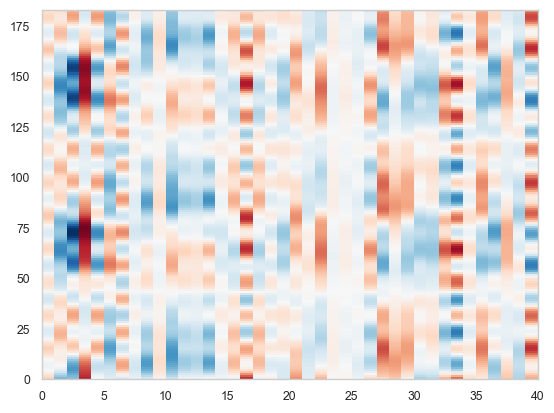

In [43]:

plt.pcolormesh(test_recons, **pcolor_kwargs)